In [88]:
import csv
import os
from datetime import datetime
import math
import matplotlib.pyplot as plt

In [89]:
call_files = []

options_dir = '../data/options_data'
for ticker in os.listdir(options_dir):
    ticker_dir = options_dir + '/' + ticker
    for file in os.listdir(ticker_dir):
        file_heruistics = file.split('_')
        strike = file_heruistics[2].split('-', 1)
        expiry_date = datetime.strptime(file_heruistics[1], '%Y%m%d').date()

        if 'c' in strike[0].replace('.csv', ''):
            call_files.append((file, expiry_date))

    call_files.sort(key=lambda contract: contract[1])

    #implement covered call strategy
    balance = 100000
    ownUnderlying = False
    underlyingQuantity = 0 # in hundreds

    csv_data = []

    for file, expiry_date in call_files:
        with open(os.path.join(ticker_dir, file), 'r') as f:
            strike_csv = csv.reader(f)
            row = list(strike_csv)

            for index, line in reversed(list(enumerate(row[0:len(row)-1]))):
                date = datetime.strptime(line[0], '%m/%d/%Y').date()
                if date.month == expiry_date.month:
                    start_open = float(row[index][1])
                    strike_price = float(row[index][16])
                    start_price = float(row[index][15])
                    end_price = float(row[1][15])
                    break

            # buy shares by the even hundreds + subtract balance
            if ownUnderlying == False:
                underlyingQuantity = math.floor(balance/(start_price * 100))
                balance -= (start_price * 100) * underlyingQuantity
                ownUnderlying = True

            # calculate profit of selling contract and add to balance
            contract_profit = underlyingQuantity * start_open * 100
            balance += contract_profit

            total_balance = balance + (underlyingQuantity * 100 * end_price)

            # obtain 'results'
            net_percentage = ((total_balance - 100000) / 100000) * 100
            net_return = total_balance - 100000

            csv_data.append([expiry_date, date, strike_price, start_price, end_price, start_open, underlyingQuantity, contract_profit, total_balance, net_percentage, net_return])

            # compare end asset price to strike price
            if end_price >= strike_price:
                stockSale = underlyingQuantity * 100 * end_price
                balance += stockSale

                ownUnderlying = False
                underlyingQuantity = 0

    with open('../data/outputs/covered_call/' + ticker + '.csv', 'w', newline="") as f:
        writer = csv.writer(f)

        header = ['Expiration Date', 'Date Contact Sold', 'Strike Price', 'Starting asset price', 'Ending Asset Price', 'Price Per Contract', 'Contracts Sold', 'Contract Profit', 'Monthly Ending Balance', 'Percent Change', 'Profit Amount']
        writer.writerow(header)

        for row in csv_data:
            writer.writerow(row)

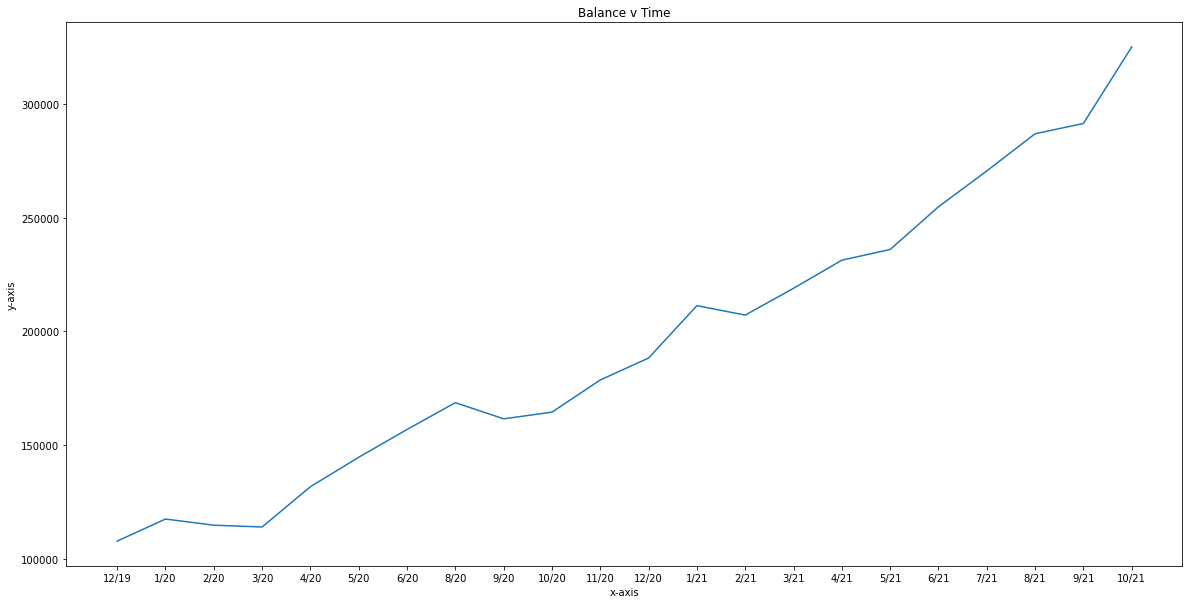

In [90]:
# graph results using matlab pyplot

outputs = '../data/outputs/covered_call/'
files = [os.path.join(outputs, f) for f in os.listdir(outputs) if
         os.path.isfile(os.path.join(outputs, f))]

for file in files:
    with open(file, 'r') as f:
        output_csv = csv.reader(f)
        rows = list(output_csv)
        
        profits = []
        monthly_balance = []

        for line in rows[1:]:
            profits.append(round(float(line[10]), 2))
            monthly_balance.append(round(float(line[8]),2))
            
        x1 = ['12/19','1/20','2/20','3/20','4/20',
            '5/20','6/20','8/20','9/20','10/20',
            '11/20','12/20','1/21','2/21','3/21','4/21',
            '5/21','6/21','7/21','8/21','9/21','10/21']

        y1 = monthly_balance

        return_plt = plt.figure()
        return_plt.set_figheight(10)
        return_plt.set_figwidth(20)
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.title('Balance v Time')
        plt.plot(x1, y1)
        plt.savefig('../data/outputs/covered_call/graphs/' + ticker + '_balance_v_time.jpg')
        plt.show()
        
